In [4]:
import numpy as np
import pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import text_to_word_sequence
import re, os

from keras.models import Model

from keras.layers import Input
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import LSTM, Bidirectional
%matplotlib notebook
import matplotlib.pyplot as plt
from nltk import download
from nltk.corpus import stopwords
from tqdm import tqdm

import keras
import tensorflow as tf

In [5]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3830480222667083754
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3104047104
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6185950907078175328
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 960M, pci bus id: 0000:02:00.0, compute capability: 5.0"
]


In [6]:
seed = 7
np.random.seed(seed)

# the model gonna be export at this file
filename = 'model/model_saved_lstm.h5'

epochs = 5

#word embedding dimensionality in pre trained
word_embedding_dim = 50

# sample number to be use in each update of gradient
batch_size = 32

# reflect the max amount of words which we keep in vocabolary
max_features = 5000

#dimension of output in embedding layer
embed_dim = 128

# size limit of sequence when generate the tokenizer
max_sequence_length = 300

pre_trained_wv = False

bilstm = False

In [7]:
# remove charactere no desired

def clean_str(string):
    string = re.sub(r"[^A-Za-z0-9(),!?\1\'\`]", " ", string)
    string = re.sub(r"\'s'", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"\'t", " \'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \(", string)
    string = re.sub(r"\)", " \)", string)
    string = re.sub(r"\?", " \?", string)
    string = re.sub(r"\s{2,}", " ", string)
    
    cleanr = re.compile('<.*?>')
    
    string = re.sub(f'\d+', '', string)
    string = re.sub(cleanr, '', string)
    string = re.sub("'", '', string)
    string = re.sub("'", '', string)
    string = re.sub(r'\W+', ' ', string)
    string = string.replace('_', '')
    
    return string.strip().lower()
    
    

In [8]:
def prepare_data(data):
    download('stopwords')
    data = data[['text', 'sentiment']]
    
    data['text'] = data['text'].apply(lambda x: x.lower())
    data['text'] = data['text'].apply(lambda x: clean_str(x))
    data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-Z0-9\s]', '', x)))
    
    stop_words = set(stopwords.words('english'))
    text = []
    for row in data['text'].values:
        word_list = text_to_word_sequence(row)
        no_stop_words = [w for w in word_list if not w in stop_words]
        no_stop_words = " ".join(no_stop_words)
        text.append(no_stop_words)
        
    tokenizer = Tokenizer(num_words=max_features, split=' ')
    
    tokenizer.fit_on_texts(text)
    x = tokenizer.texts_to_sequences(text)
    
    x = pad_sequences(x, maxlen=max_sequence_length)

    word_index = tokenizer.word_index
    y = pd.get_dummies(data['sentiment']).values
    X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.20, random_state=42)
    
    return X_train, X_test, Y_train, Y_test, word_index, tokenizer

In [10]:
data = pd.read_excel('./dataset/imdb.xlsx', engine='openpyxl')

X_train, X_test, Y_train, Y_test, word_index, tokenizer = prepare_data(data)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


(40000, 300) (40000, 2)
(10000, 300) (10000, 2)


In [12]:
def model():
    
    input_shape = (max_sequence_length,)
    model_input = Input(shape=input_shape, name="input", dtype='int32')
    
    embedding = Embedding(
        max_features, 
        embed_dim, 
        name="embedding", 
        input_length=max_sequence_length
    )(model_input)
    
    lstm = LSTM(embed_dim, dropout=0.2, recurrent_dropout=0.2, name='lstm')(embedding)
    
    model_output = Dense(2, activation='softmax', name='softmax')(lstm)
    model = Model(inputs=model_input, outputs=model_output)
    return model

In [13]:
model = model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 300)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 128)          640000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
softmax (Dense)              (None, 2)                 258       
Total params: 771,842
Trainable params: 771,842
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
# if not os.path.exists(f'./{filename}'):
    
hist = model.fit(
    X_train,
    Y_train,
    validation_data=(X_test, Y_test),
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    verbose=1
)

model.save_weights(filename)

Epoch 1/5
1250/1250 [==============================] - 477s 380ms/step - loss: 0.3595 - accuracy: 0.8463 - val_loss: 0.2928 - val_accuracy: 0.8774
Epoch 2/5
1250/1250 [==============================] - 488s 390ms/step - loss: 0.2561 - accuracy: 0.8984 - val_loss: 0.2869 - val_accuracy: 0.8797
Epoch 3/5
1250/1250 [==============================] - 496s 397ms/step - loss: 0.2167 - accuracy: 0.9166 - val_loss: 0.2887 - val_accuracy: 0.8857
Epoch 4/5
1250/1250 [==============================] - 497s 397ms/step - loss: 0.2104 - accuracy: 0.9168 - val_loss: 0.3117 - val_accuracy: 0.8853
Epoch 5/5
1250/1250 [==============================] - 486s 389ms/step - loss: 0.1568 - accuracy: 0.9404 - val_loss: 0.3611 - val_accuracy: 0.8537


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KeyError: 'acc'

<IPython.core.display.Javascript object>


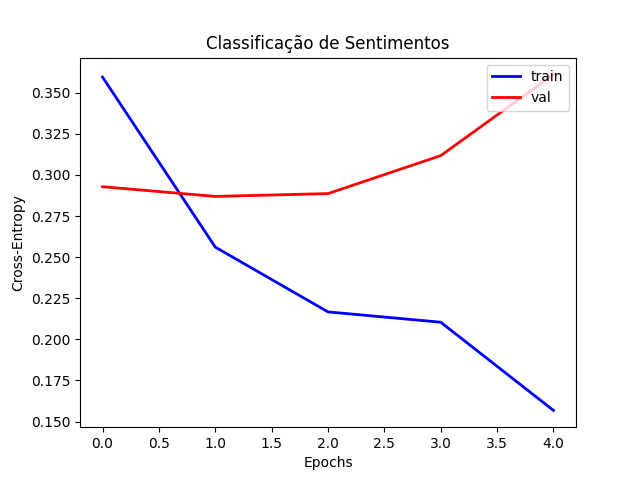

<IPython.core.display.Javascript object>


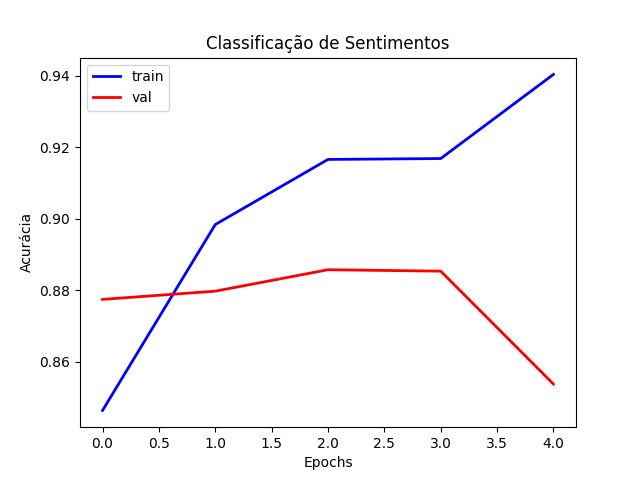

In [15]:
hist.history

plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('Classificação de Sentimentos')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend(loc='upper right')
plt.show()

plt.figure()
plt.plot(hist.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('Classificação de Sentimentos')
plt.xlabel('Epochs')
plt.ylabel('Acurácia')
plt.legend(loc='upper left')
plt.show()

In [26]:
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print(f"Acc: {score[1]*100}%")
while True:
    sentence = input("input> ")
    if sentence == "exit":
        break
        
    next_text = [sentence]
    next_text = tokenizer.texts_to_sequences(next_text)
    new_text = pad_sequences(next_text, maxlen=max_sequence_length, dtype='int32', value=0)
    
    sentiment = model.predict(new_text, batch_size=1, verbose=2)[0]
    
    if (np.argmax(sentiment) == 0):
        print(f"negativo => {round(sentiment[0]*100, 3)}")
    else:
        print(f"positivo => {round(sentiment[1]*100, 3)}")

Acc: 87.43000030517578%
input> Terrible! Do not purchase! The coating on the knife comes off, very quickly! The coating came off and attached to a dessert I was making.
1/1 - 0s - 235ms/epoch - 235ms/step
negativo => 99.949
input> These are a great set and super sharp. I got the set for my camper, so I will only be washing these by hand. I thought that there was a nice array of knives and the handles fit well in my hands. A couple of the covers on the knives were loose fitting and that would be a possible safety issue if you are worried about small children. Mine just need the covers to keep from rubbing in the drawer, especially during the bumpy trailer transport. My mom used a couple while they were camping with us, and she said that she liked them a lot as well.
1/1 - 0s - 30ms/epoch - 30ms/step
positivo => 99.999
input> The best thing about these knives is that each one has a protective cover. Bear with me while I explain...... I am retired and live in an independent living facilit

<IPython.core.display.Javascript object>


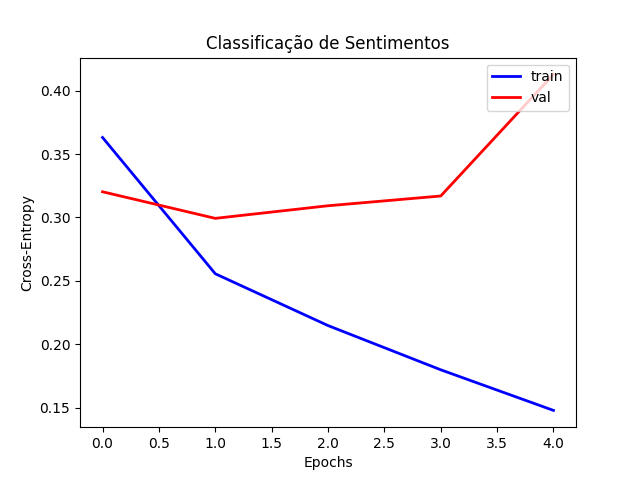

<IPython.core.display.Javascript object>


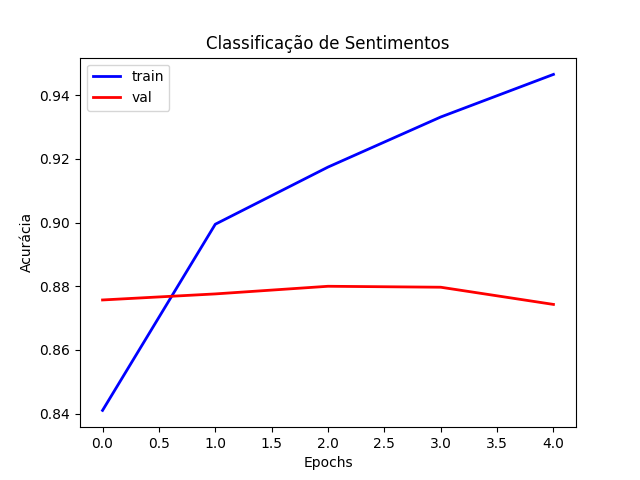

In [27]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0
